In [3]:
from fbpinns.problems import Problem
import jax.numpy as jnp
import jax

class WaveEquation2D(Problem):
    """Solves the time-dependent 1D viscous Burgers equation
        d^2 u       d^2 u    
        ----- - c^2 ----- = 0
        d t^2       d x^2    

        for (x, t) in [0, 1]^2

        Boundary conditions:
        u(0, t) = 0
        u(1, t) = 0
        u(x, 0) = sin(πx) + 0.5 sin(4πx)
        u_t(x, 0) = 0
    """

    @staticmethod
    def init_params(c=jnp.sqrt(2), sd=0.1):

        static_params = {
            "dims":(1,2),
            "c":c,
            "sd":sd,
            }
        
        return static_params, {}

    @staticmethod
    def sample_constraints(all_params, domain, key, sampler, batch_shapes):

        # physics loss
        x_batch_phys = domain.sample_interior(all_params, key, sampler, batch_shapes[0])
        required_ujs_phys = (
            (0,(0,0)),
            (0,(1,1)),
        )
        return [[x_batch_phys, required_ujs_phys],]


    @staticmethod
    def constraining_fn(all_params, x_batch, u):
        sd = all_params["static"]["problem"]["sd"]
        x, t, tanh, sin, pi = x_batch[:,0:1], x_batch[:,1:2], jax.nn.tanh, jnp.sin, jnp.pi
        u = tanh(x/sd) * tanh((1-x)/sd) * t**2 * u  + (sin(pi*x) + 0.5 * sin(4*pi*x))
        return u

    @staticmethod
    def loss_fn(all_params, constraints):
        c = all_params["static"]["problem"]["c"]
        _, uxx, utt = constraints[0]
        phys = utt - c**2 * uxx
        mse = jnp.mean(phys**2)
        return mse, phys
    
    @staticmethod
    def exact_solution(all_params, x_batch, batch_shape):

        c = all_params["static"]["problem"]["c"]
        x, t, sin, cos, pi = x_batch[:,0:1], x_batch[:,1:2], jnp.sin, jnp.cos, jnp.pi
        u = sin(pi*x)*cos(c*pi*t) + 0.5 * sin(4*pi*x)*cos(4*c*pi*t)
        return u

[Errno 16] Device or resource busy: 'results/summaries/test/.nfs0000000062895d050000001f'
[INFO] 2025-05-15 13:33:39 - <fbpinns.constants.Constants object at 0x73e82cf4e510>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class '__main__.WaveEquation2D'>
problem_init_kwargs: {}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([0.  , 0.25, 0.5 , 0.75, 1.  ])], 'subdomain_ws': [array([0.725, 0.725, 0.725, 0.725, 0.725]), array([0.725, 0.725, 0.725, 0.725, 0.725])], 'unnorm': (0.0, 5.0)}
network: <class 'fbpinns.networks.GeneralizedStackedChebyshevKAN'>
network_init_kwargs: {'dims': [2, 4, 1], 'degrees': [4, 4]}
n_steps: 40000
scheduler: <class 'fbpinns.schedulers.AllActiveSchedulerND'>
scheduler_kwargs: {}
ns: ((200, 200),)
n_test: (200, 200)
sampler: grid
optimiser: <function a

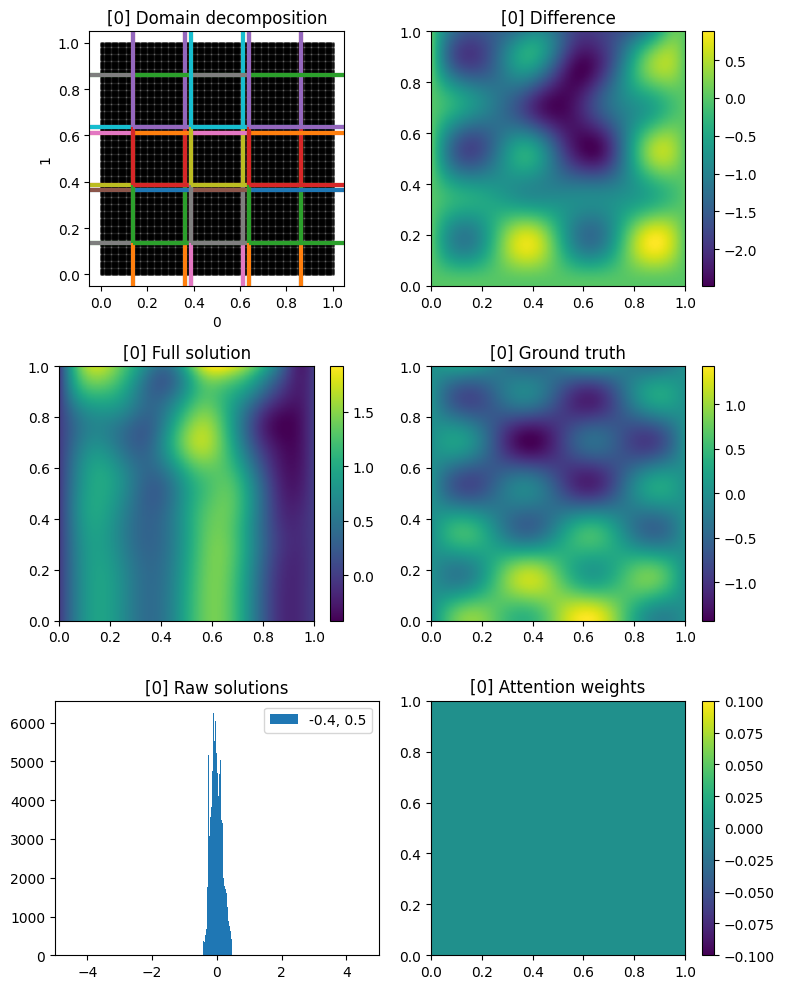

[INFO] 2025-05-15 13:34:12 - [i: 1000/40000] loss: 206.9728 rate: 37.8 elapsed: 0.01 hr test
[INFO] 2025-05-15 13:34:33 - [i: 2000/40000] loss: 21.7573 rate: 48.4 elapsed: 0.01 hr test
[INFO] 2025-05-15 13:34:53 - [i: 3000/40000] loss: 2.4733 rate: 50.9 elapsed: 0.02 hr test
[INFO] 2025-05-15 13:35:10 - [i: 4000/40000] loss: 0.8096 rate: 59.3 elapsed: 0.02 hr test
[INFO] 2025-05-15 13:35:30 - [i: 5000/40000] loss: 0.4331 rate: 48.5 elapsed: 0.03 hr test
[INFO] 2025-05-15 13:35:31 - saved arrays


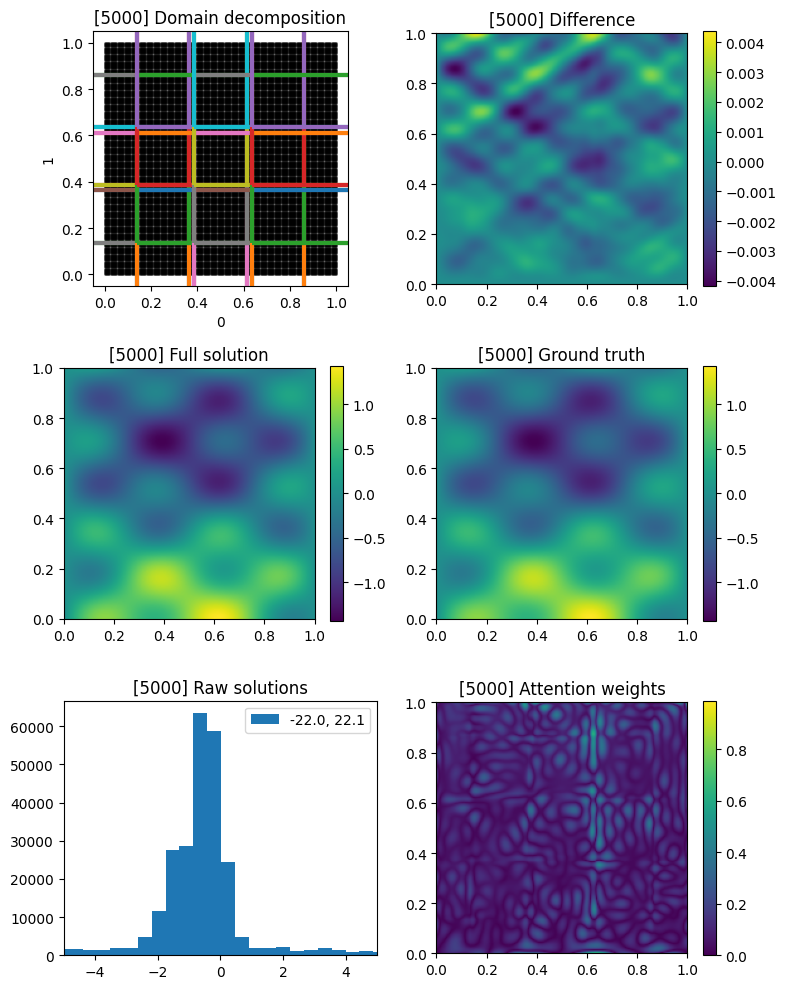

[INFO] 2025-05-15 13:35:52 - [i: 6000/40000] loss: 0.3147 rate: 48.4 elapsed: 0.04 hr test
[INFO] 2025-05-15 13:36:11 - [i: 7000/40000] loss: 0.5859 rate: 53.5 elapsed: 0.04 hr test
[INFO] 2025-05-15 13:36:29 - [i: 8000/40000] loss: 0.2653 rate: 55.3 elapsed: 0.05 hr test
[INFO] 2025-05-15 13:36:50 - [i: 9000/40000] loss: 0.2059 rate: 48.4 elapsed: 0.05 hr test
[INFO] 2025-05-15 13:37:11 - [i: 10000/40000] loss: 0.1855 rate: 48.4 elapsed: 0.06 hr test
[INFO] 2025-05-15 13:37:11 - saved arrays


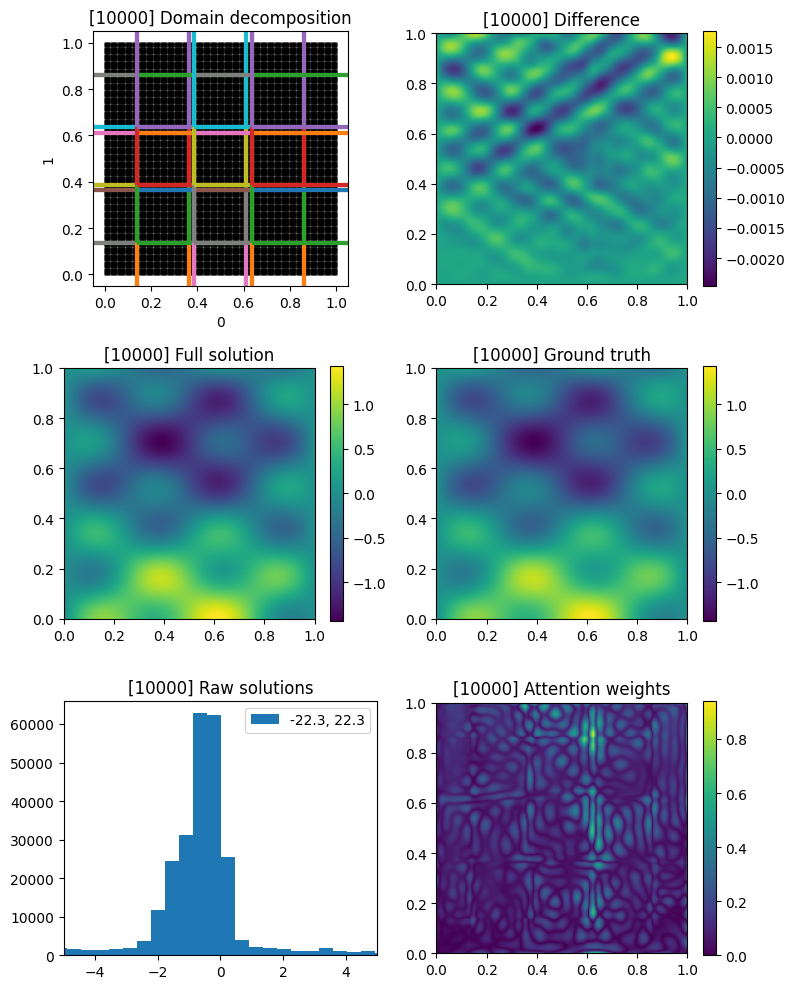

[INFO] 2025-05-15 13:37:29 - [i: 11000/40000] loss: 0.8241 rate: 58.1 elapsed: 0.06 hr test
[INFO] 2025-05-15 13:37:49 - [i: 12000/40000] loss: 0.4286 rate: 51.3 elapsed: 0.07 hr test
[INFO] 2025-05-15 13:38:10 - [i: 13000/40000] loss: 0.5736 rate: 48.4 elapsed: 0.07 hr test
[INFO] 2025-05-15 13:38:30 - [i: 14000/40000] loss: 0.1906 rate: 48.4 elapsed: 0.08 hr test
[INFO] 2025-05-15 13:38:46 - [i: 15000/40000] loss: 0.1291 rate: 62.7 elapsed: 0.08 hr test
[INFO] 2025-05-15 13:38:47 - saved arrays


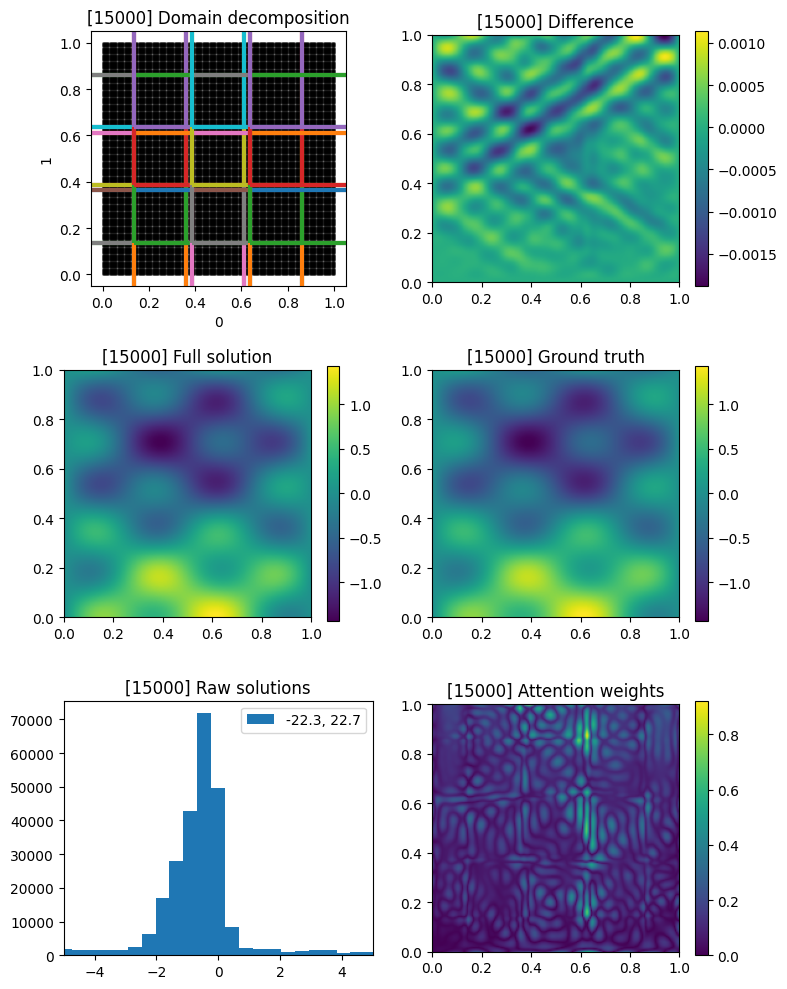

[INFO] 2025-05-15 13:39:08 - [i: 16000/40000] loss: 0.2779 rate: 48.5 elapsed: 0.09 hr test
[INFO] 2025-05-15 13:39:29 - [i: 17000/40000] loss: 0.6263 rate: 48.4 elapsed: 0.10 hr test
[INFO] 2025-05-15 13:39:49 - [i: 18000/40000] loss: 0.3220 rate: 51.3 elapsed: 0.10 hr test
[INFO] 2025-05-15 13:40:06 - [i: 19000/40000] loss: 0.1005 rate: 58.0 elapsed: 0.11 hr test
[INFO] 2025-05-15 13:40:27 - [i: 20000/40000] loss: 0.1235 rate: 48.5 elapsed: 0.11 hr test
[INFO] 2025-05-15 13:40:27 - saved arrays


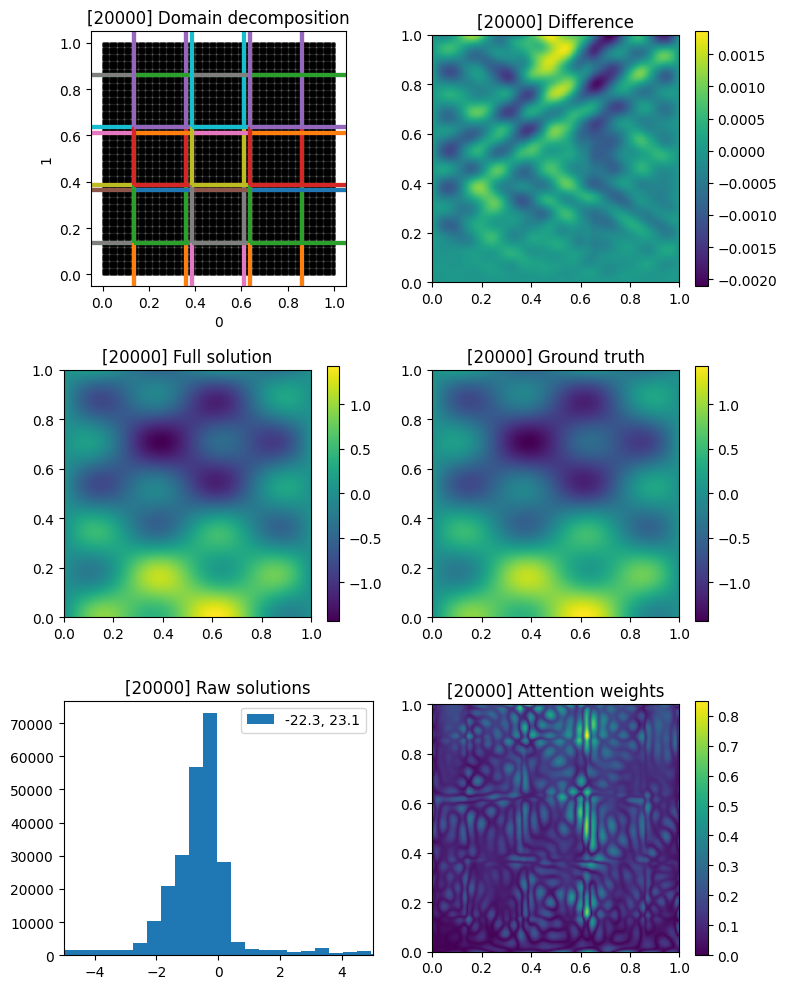

[INFO] 2025-05-15 13:40:49 - [i: 21000/40000] loss: 0.0964 rate: 48.4 elapsed: 0.12 hr test
[INFO] 2025-05-15 13:41:07 - [i: 22000/40000] loss: 0.1893 rate: 54.4 elapsed: 0.12 hr test
[INFO] 2025-05-15 13:41:25 - [i: 23000/40000] loss: 0.1653 rate: 54.8 elapsed: 0.13 hr test
[INFO] 2025-05-15 13:41:46 - [i: 24000/40000] loss: 0.0860 rate: 48.6 elapsed: 0.13 hr test
[INFO] 2025-05-15 13:42:07 - [i: 25000/40000] loss: 0.2892 rate: 48.4 elapsed: 0.14 hr test
[INFO] 2025-05-15 13:42:07 - saved arrays


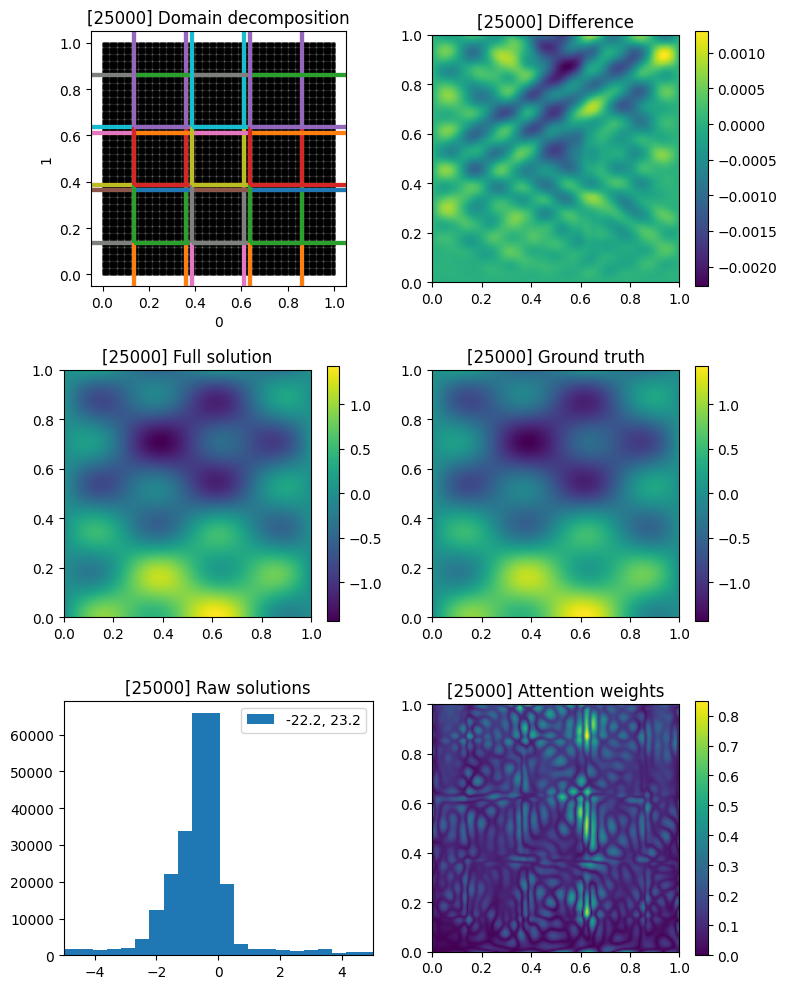

[INFO] 2025-05-15 13:42:25 - [i: 26000/40000] loss: 0.3069 rate: 59.0 elapsed: 0.14 hr test
[INFO] 2025-05-15 13:42:45 - [i: 27000/40000] loss: 0.1022 rate: 50.6 elapsed: 0.15 hr test
[INFO] 2025-05-15 13:43:05 - [i: 28000/40000] loss: 0.0763 rate: 48.4 elapsed: 0.16 hr test
[INFO] 2025-05-15 13:43:26 - [i: 29000/40000] loss: 0.0972 rate: 48.4 elapsed: 0.16 hr test
[INFO] 2025-05-15 13:43:42 - [i: 30000/40000] loss: 0.0687 rate: 62.7 elapsed: 0.17 hr test
[INFO] 2025-05-15 13:43:43 - saved arrays


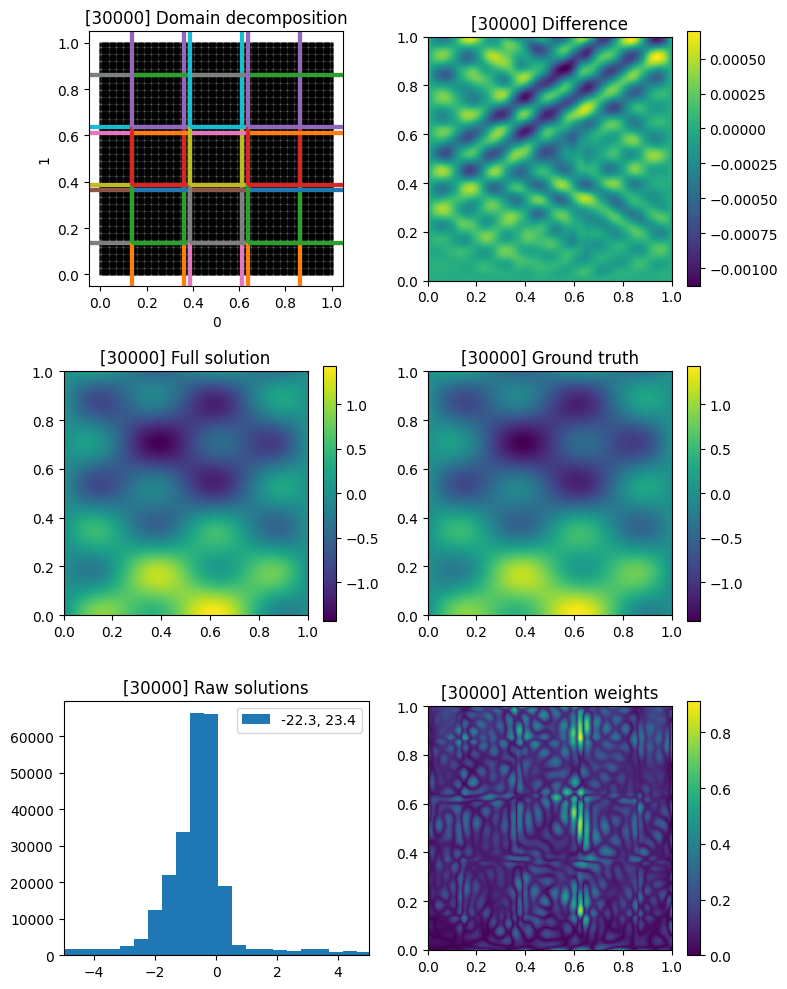

[INFO] 2025-05-15 13:44:04 - [i: 31000/40000] loss: 0.5254 rate: 48.5 elapsed: 0.17 hr test
[INFO] 2025-05-15 13:44:25 - [i: 32000/40000] loss: 0.3397 rate: 48.4 elapsed: 0.18 hr test
[INFO] 2025-05-15 13:44:44 - [i: 33000/40000] loss: 0.0655 rate: 51.6 elapsed: 0.18 hr test
[INFO] 2025-05-15 13:45:02 - [i: 34000/40000] loss: 0.0645 rate: 57.3 elapsed: 0.19 hr test
[INFO] 2025-05-15 13:45:23 - [i: 35000/40000] loss: 0.1090 rate: 48.5 elapsed: 0.19 hr test
[INFO] 2025-05-15 13:45:23 - saved arrays


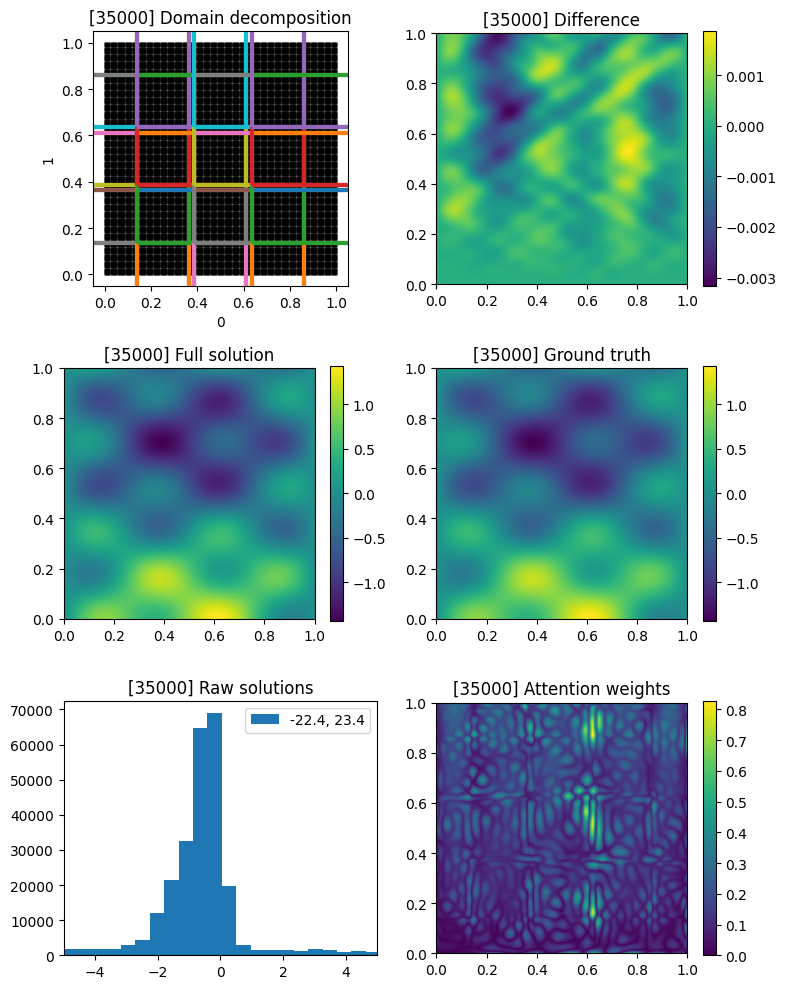

[INFO] 2025-05-15 13:45:45 - [i: 36000/40000] loss: 0.1313 rate: 48.5 elapsed: 0.20 hr test
[INFO] 2025-05-15 13:46:03 - [i: 37000/40000] loss: 0.0594 rate: 55.2 elapsed: 0.21 hr test
[INFO] 2025-05-15 13:46:22 - [i: 38000/40000] loss: 0.0572 rate: 53.8 elapsed: 0.21 hr test
[INFO] 2025-05-15 13:46:43 - [i: 39000/40000] loss: 0.0581 rate: 48.4 elapsed: 0.22 hr test
[INFO] 2025-05-15 13:47:03 - [i: 40000/40000] loss: 0.0811 rate: 48.4 elapsed: 0.22 hr test
[INFO] 2025-05-15 13:47:04 - saved arrays


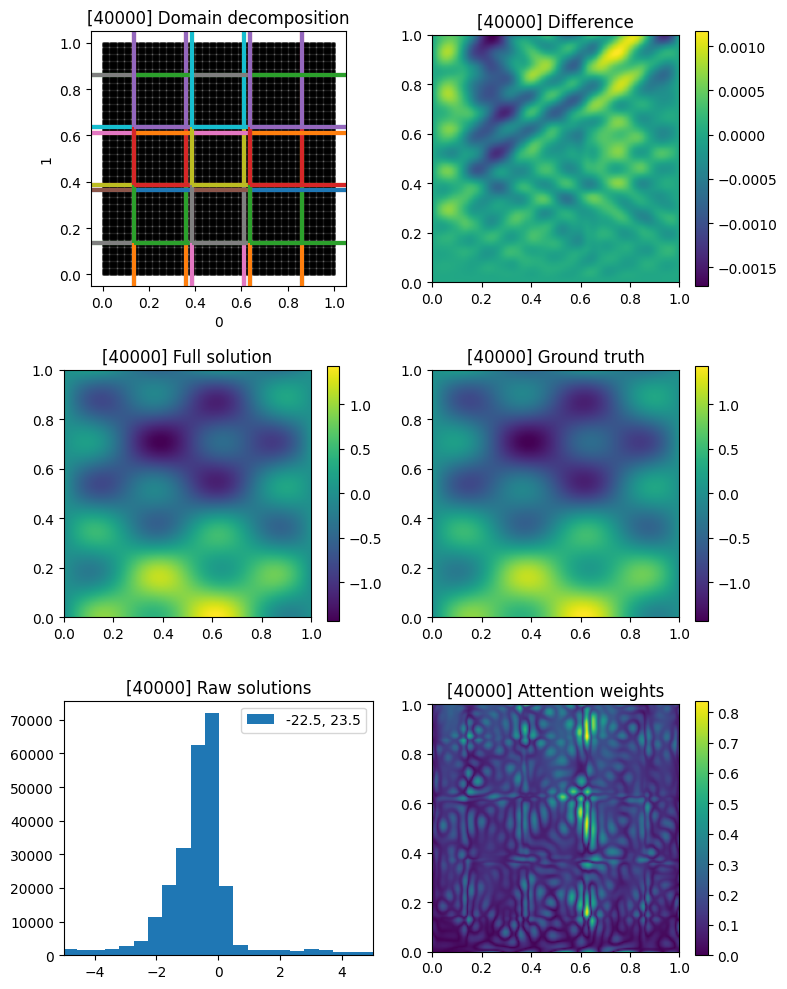

[INFO] 2025-05-15 13:47:04 - [i: 40000/40000] Training complete
[INFO] 2025-05-15 13:47:04 - [i: 40000/40000] Total training time: 800.57 s


In [5]:
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, ChebyshevAdaptiveKAN, StackedChebyshevKAN, GeneralizedStackedChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.attention import RBAttention

subdomain_xs=[np.linspace(0,1,5), np.linspace(0,1,5)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=WaveEquation2D,
    problem_init_kwargs = dict(
        # c=2
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0.,5.),
    ),
    # network=FCN,
    # network_init_kwargs = dict(
    #     layer_sizes = (2, 16, 16, 1),
    # ),
    # network=StackedChebyshevKAN,
    # network_init_kwargs=dict(
    #     input_dim=2,
    #     hidden_dim=4,
    #     output_dim=1,
    #     degree=6
    # ),
    # scheduler = LineSchedulerRectangularND,
    # scheduler_kwargs = dict(
    #     point=[0.], iaxis=0,
    # ),
    network=GeneralizedStackedChebyshevKAN,
    network_init_kwargs = dict(
        dims=[2, 4, 1],
        degrees=[4, 4]
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,200),),
    n_test=(200,200),
    n_steps=40000,
    clear_output=False,
    attention_tracker=RBAttention,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.99,
        out_dim=1,
        N=40000
        ),
    )

run = FBPINNTrainer(c)
all_params = run.train()

In [ ]:
all_params

{'static': {'domain': {'xd': 2,
   'xmin': Array([0., 0.], dtype=float32),
   'xmax': Array([1., 1.], dtype=float32)},
  'problem': {'dims': (1, 2),
   'c': Array(1.4142135, dtype=float32, weak_type=True),
   'sd': 0.1},
  'decomposition': {'m': 100,
   'xd': 2,
   'subdomain': {'params': [Array([[-0.16111112, -0.16111112],
            [-0.16111112, -0.05      ],
            [-0.16111112,  0.06111111],
            [-0.16111112,  0.17222223],
            [-0.16111112,  0.28333333],
            [-0.16111112,  0.39444444],
            [-0.16111112,  0.50555557],
            [-0.16111112,  0.6166667 ],
            [-0.16111112,  0.7277778 ],
            [-0.16111112,  0.8388889 ],
            [-0.05      , -0.16111112],
            [-0.05      , -0.05      ],
            [-0.05      ,  0.06111111],
            [-0.05      ,  0.17222223],
            [-0.05      ,  0.28333333],
            [-0.05      ,  0.39444444],
            [-0.05      ,  0.50555557],
            [-0.05      ,  0.61666